In [1]:
# Install library for reading JPK File
# %pip uninstall pyafmreader --yes
# %pip install git+https://github.com/jlopezalo/pyafmreader.git

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-4zo6e5ma
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-4zo6e5ma
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=32688 sha256=0cc148fe6bcc42bf445b50ddace61a47b954774d3594cce664622d7e8dd63d6c
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-2ima8w8t/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 30 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
file = loadfile(file_path)

In [6]:
filemetadata = file.filemetadata
print(filemetadata)

{'file_path': '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map', 'Entry_filename': 'map-data-2021.11.05-15.41.45.699.jpk-force-map', 'file_size_bytes': 1117407, 'file_type': '.jpk-force-map', 'UFF_code': '_1_2_3_4_5', 'Entry_UFF_version': '0', 'file_id': '15.41.45.699', 'force_volume': 1, 'Experimental_instrument': 'JPK00180', 'JPK_file_format_version': '2.0', 'JPK_software_version': '6.3.48', 'retracted_delay': 0.0, 'extended_delay': 0.0, 'Entry_date': '2021-11-05 15\\:41\\:45.699 +0100', 'scan_angle': -0.0, 'num_x_pixels': 4, 'num_y_pixels': 4, 'scan_size_x': 4999.999999999999, 'scan_size_y': 4999.999999999999, 'z_closed_loop': 'false', 'Recording_Z_close_loop_on': 'Off', 'Entry_tot_nb_curve': 16, 'extend_pause_duration': 0.0, 'force_setpoint': 1.3357704473718137, 'nbr_channels': 3, 'defl_sens_nmbyV': 38.48140786850581, 'spring_const_Nbym': 0.009727186009888375, 'channel_properties': {'height': {'channel_id': 0, 'encoder_offet_key': 

In [7]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant
    
print(file_spring_constant)
print(deflection_sensitivity)

0.009727186009888375
3.8481407868505814e-08


In [8]:
curve_idx = 5
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

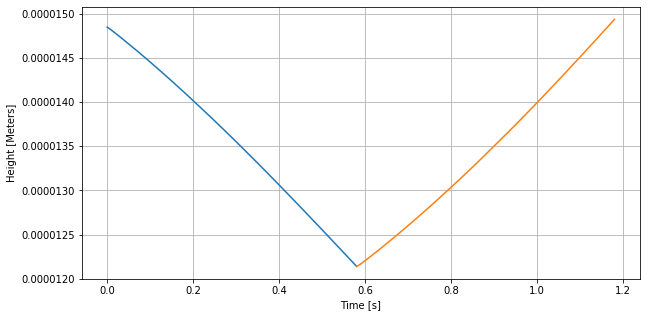

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    if seg_id == '1':
         height = height[::-1]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

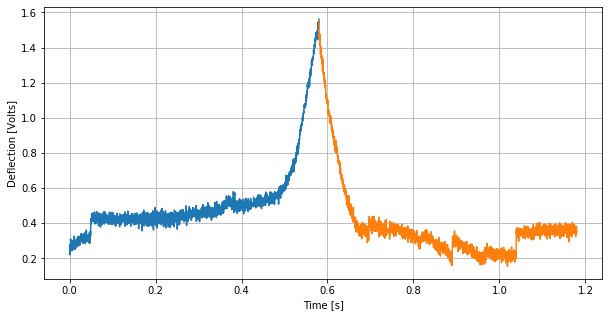

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

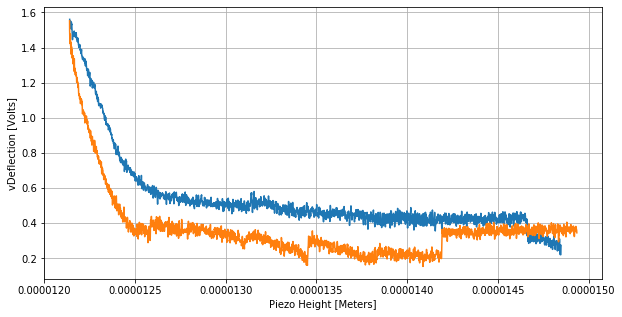

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)

# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]

In [13]:
# Shift height
force_curve.shift_height()

In [14]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [15]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

2.1396929367307326e-06 1.1482232090130871e-08


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


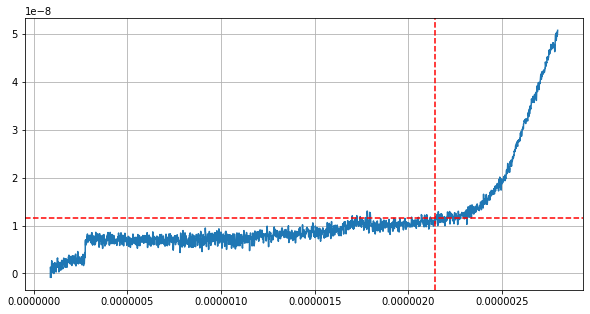

In [16]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

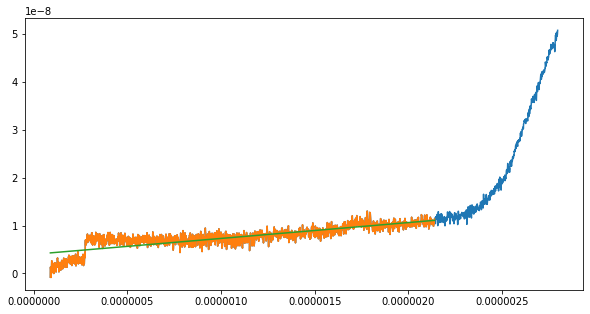

In [17]:
plt.plot(app_height, app_deflection)
mask = app_height<poc[0]
plt.plot(app_height[mask], app_deflection[mask])
z = np.poly1d(np.polyfit(app_height[mask], app_deflection[mask], 1))
plt.plot(app_height[mask], z(app_height[mask]))

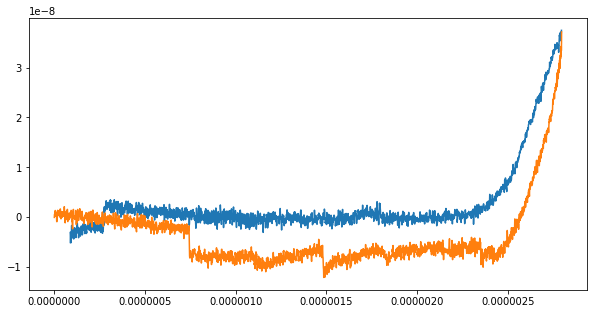

In [18]:
plt.plot(app_height, app_deflection-z(app_height))
plt.plot(ret_height, ret_deflection-z(ret_height))
first_ext_seg.vdeflection = app_deflection-z(app_height)
last_ret_seg.vdeflection = ret_deflection-z(ret_height)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: 2.59636356684136e-07

        E0: 5488.957944496129

        f0: -1.0984098947910867e-10

        slope: None

        # Fit metrics
        MAE: -1.5348252179677216e-21

        MSE: 1.693348997274683e-22

        RMSE: 1.301287438375812e-11

        Rsq: 0.9646693015601701

        Chisq: -4.215752238294313e-09

        RedChisq: -1.4052507460981044e-09

        
5488.957944496129


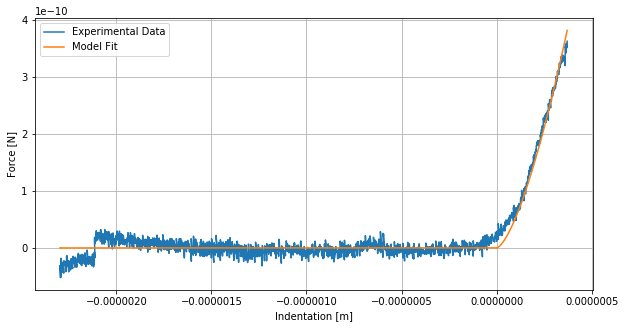

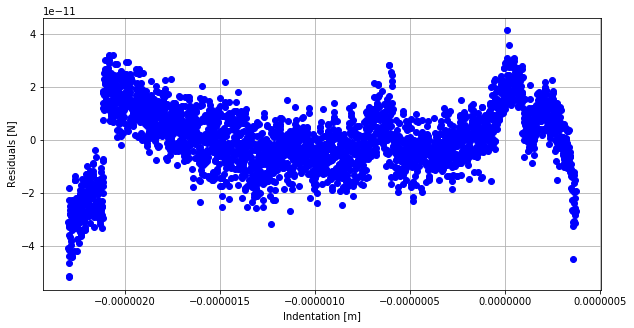

In [19]:
# Hertz fit
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

# plt.plot(app_height - poc[0], app_deflection*spring_constant)
# plt.show()

# app_indentation = app_height - poc[0]
# app_force = app_deflection*spring_constant

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

print(hertz_E0)

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [20]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

In [21]:
indentation = np.r_[app_indentation, ret_indentation]
force = np.r_[app_force, ret_force]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]
fit_mask = indentation > (-0.5 * 1e-6)
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
time_fit = time_fit - time_fit[0]
tm = time_fit[np.argmax(force_fit)]
tc = tm/3
idx_tm = np.argmax(force_fit)

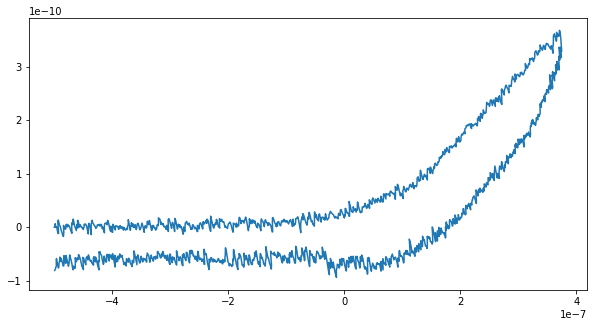

In [22]:
plt.plot(ind_fit, force_fit)
plt.show()

In [23]:
help(TingModel)

Help on class TingModel in module pyafmrheo.models.ting:

class TingModel(builtins.object)
 |  TingModel(ind_geom, tip_param, modelFt) -> None
 |  
 |  Methods defined here:
 |  
 |  SolveAnalytical(self, ttc, trc, t1, model_probe, geom_coeff, v0t, v0r, v0, E0, betaE, t0, F0, vdrag)
 |  
 |  SolveNumerical(self, delta, time_, geom_coeff, geom_exp, v0t, v0r, E0, betaE, F0, vdrag, smooth_w, idx_tm, idxCt, idxCr)
 |  
 |  __init__(self, ind_geom, tip_param, modelFt) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  fit(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  fit_report(self)
 |  
 |  get_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  get_red_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  get_residuals(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  objective(self, time, E0, tc, betaE, F0, t0, F, delta, m

In [24]:
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
ting_model_num.betaE_init = 0.2
ting_model_num.E0_init = hertz_E0
ting_model_num.tc_init = tc
ting_model_num.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5)
ting_model_num.fit_report()
tc_num = ting_model_num.tc
f0_num = ting_model_num.F0

/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:76: RuntimeWarning: invalid value encountered in power
  A = smoothM(np.r_[numdiff(delta0[idxCt]**geom_exp), numdiff(delta0[idxCr[0]:]**geom_exp)], smooth_w)



        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 888

        Number of free parameters: 4

        E0: 2241.057745957836

        tc: 0.07466541963049525

        betaE: 0.06768816541217483

        F0: -4.098818982890032e-11

        # Fit metrics
        MAE: -3.5737885396916985e-12

        MSE: 2.0826441793616937e-21

        RMSE: 4.5635996530827434e-11

        Rsq: 0.8361002031021902

        Chisq: 1.79392690965131e-06

        RedChisq: 4.484817274128275e-07

        


/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:232: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(time, F, delta, t0, idx_tm, smooth_w)**2/F)


In [25]:
ting_model_analit = TingModel(indenter_shape, tip_parameter, 'analytical')
ting_model_analit.betaE_init = 0.2
ting_model_analit.E0_init = hertz_E0
ting_model_analit.tc_init = tc
ting_model_analit.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5)
ting_model_analit.fit_report()
tc_analit = ting_model_analit.tc
f0_analit = ting_model_analit.F0


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 888

        Number of free parameters: 4

        E0: 3638.3917139521272

        tc: 0.10139826158784605

        betaE: 0.1549090061140628

        F0: -3.1609187265009227e-11

        # Fit metrics
        MAE: 8.73500833668714e-13

        MSE: 1.0415607765409392e-21

        RMSE: 3.227322073392954e-11

        Rsq: 0.9175859541682638

        Chisq: 1.0761014855713315e-06

        RedChisq: 2.690253713928329e-07

        


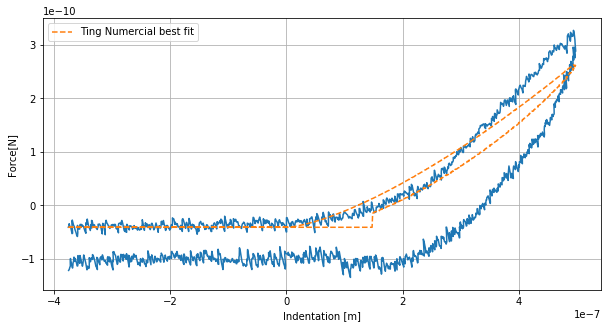

In [26]:
idx_tc = (np.abs(time_fit - tc_num)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit+f0_num)
plt.plot(ind_fit-delta0, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

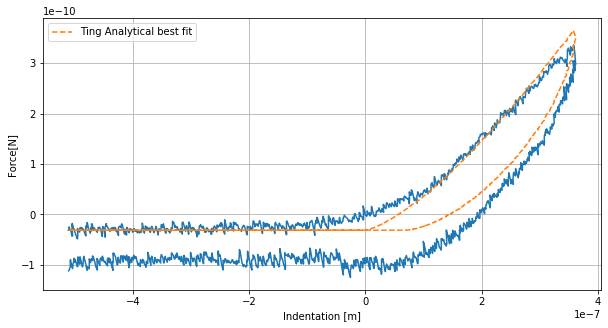

In [27]:
idx_tc = (np.abs(time_fit - tc_analit)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit+f0_analit)
plt.plot(ind_fit-delta0, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5), '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

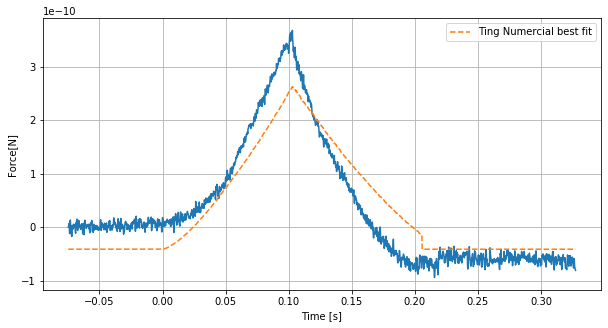

In [28]:
plt.plot(time_fit-tc_num, force_fit)
plt.plot(time_fit-tc_num, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

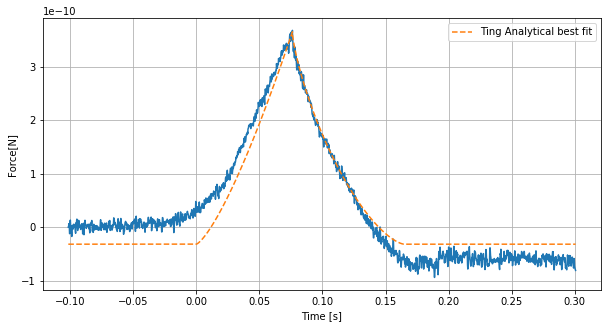

In [29]:
plt.plot(time_fit-tc_analit, force_fit)
plt.plot(time_fit-tc_analit, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Analytical best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

In [30]:
def get_AUC(indentation, force, idx_tm):
    # App
    app_ind = indentation[:idx_tm]
    app_forc = force[:idx_tm]
    auc_app = np.trapz(app_forc, app_ind)
    
    # Ret
    ret_ind = indentation[idx_tm:]
    ret_forc = force[idx_tm:]
    auc_ret = np.trapz(ret_forc, ret_ind)
    
    auc_tot = np.trapz(force, indentation)
    
    return auc_app, auc_ret, auc_tot

In [31]:
AUCApp, AUCRet, AUCTot = get_AUC(ind_fit, force_fit, idx_tm)
print(AUCApp, AUCRet, AUCTot)

6.445471164008439e-17 1.4087999228385e-17 7.87035060698494e-17


In [32]:
hertz_E0 * 1/(AUCApp-AUCRet)

1.0897987344556424e+20